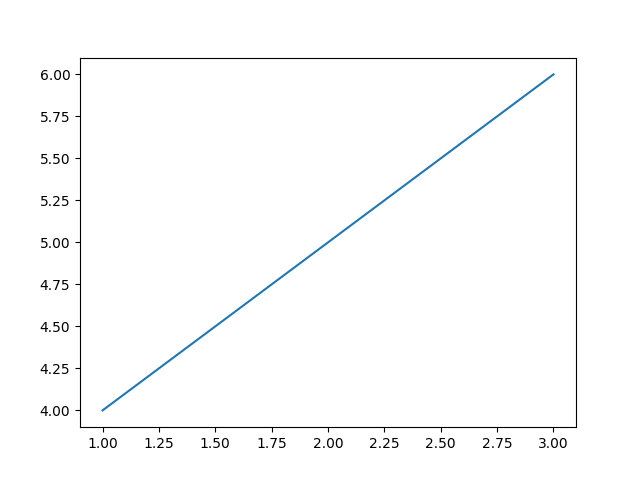

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets


#%matplotlib notebook
%matplotlib widget
 
#測試可畫
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()

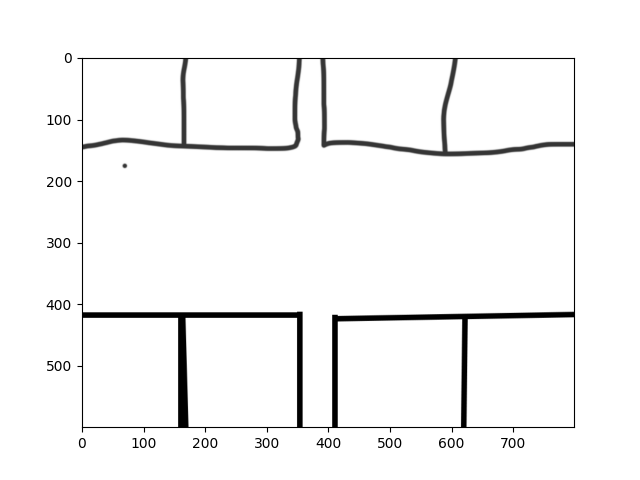

In [2]:

# 讀取 成 灰階圖片
img_path = "edge.tif"
img_rgb = cv2.imread(img_path)


# 顯示圖片
fig, ax = plt.subplots()
ax.imshow(img_rgb)

img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)


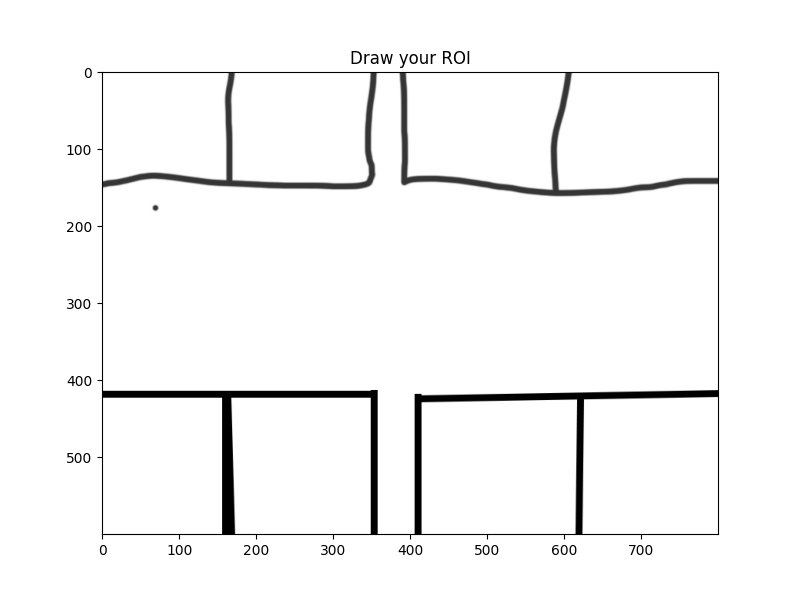

In [3]:

# 全域變數儲存ROI座標
roi_coords = []

# ROI 框選回呼函數
def onselect(eclick, erelease):
    """ 儲存使用者框選的 (x1, y1) 和 (x2, y2) 座標 """
    global roi_coords
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    roi_coords = [(x1, y1), (x2, y2)]
    print(f"選取ROI座標: ({x1}, {y1}) -> ({x2}, {y2})")

# 繪製影像並啟動選框工具
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img_rgb)
ax.set_title("Draw your ROI")

# 修正：Matplotlib 3.10.1 不再支援 drawtype 參數
rect_selector = RectangleSelector(
    ax, onselect,
    interactive=True  # 允許互動
)

plt.show()


p1= 18, 118 ; p2= 129, 163 


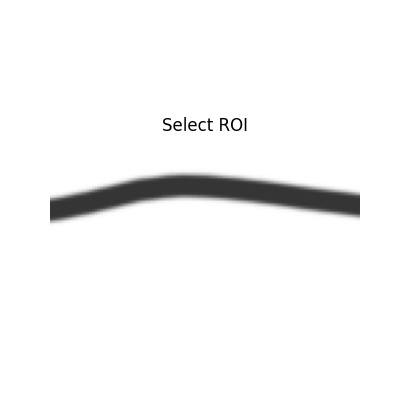

In [4]:

# 如果有選取ROI，顯示該ROI
if roi_coords:
    (x1, y1), (x2, y2) = roi_coords
    print(f"p1= {x1}, {y1} ; p2= {x2}, {y2} ")
    img_rgb_roi = img_rgb[y1:y2, x1:x2]  # 提取ROI
    img_gray_roi = cv2.cvtColor(img_rgb_roi, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb_roi)
    plt.title("Select ROI")
    plt.axis("off")
    plt.show()
else:
    print("Can not find ROI")



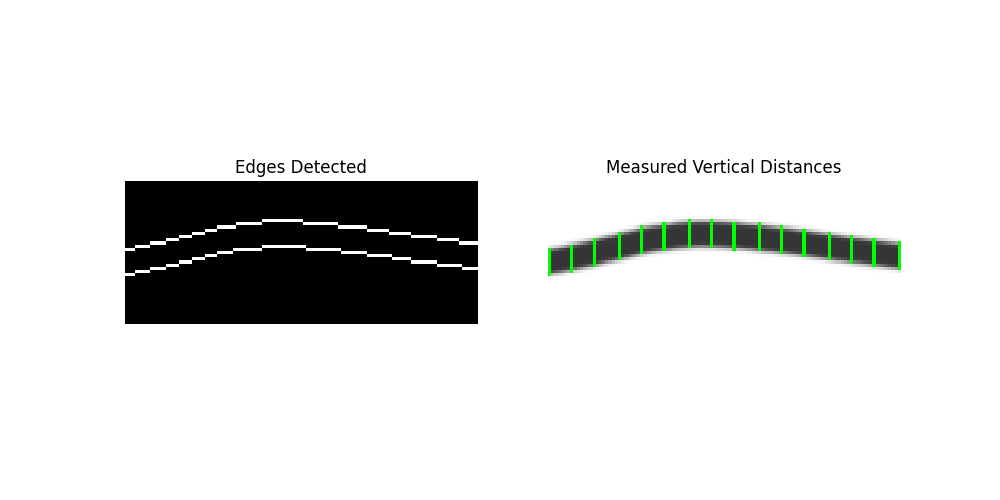

In [6]:

img_temp = img_rgb_roi.copy()
flag_dir ="vertical" # vertical or horizontal
line_num = 16




#--- --- --- Start --- --- ---



# 使用 Canny 邊緣偵測
edges = cv2.Canny(img_temp, 50, 150)

# 找到輪廓
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = max(contours, key=cv2.contourArea)  # 選擇最大輪廓
ctx, cty, ctw, cth = cv2.boundingRect(contour)

# 建立空白影像來畫出輪廓
contour_img = np.zeros_like(edges)
cv2.drawContours(contour_img, contours, -1, (255), 1)



if flag_dir == "vertical":
    vertical_lines = np.linspace(ctx, ctx+ctw-1, num=line_num, dtype=int)  # 產生?條等間距的垂直線
    for x in vertical_lines:
    #for x in range(width):
        column = np.where(contour_img[:, x] == 255)[0]  # 找出該 x 座標的白色像素
        if len(column) >= 2:
            top, bottom = column[0], column[-1]  # 取第一個與最後一個白色像素
            distance = bottom - top
            cv2.line(img_temp, (x, top), (x, bottom), (0, 255, 0), 1)
            #print(f"x={x}, t={top}, b={bottom}, d={distance}")

elif flag_dir == "horizontal":
    horizontal_lines = np.linspace(cty, cty+cth-1, num=line_num, dtype=int)
    for y in horizontal_lines:
        row = np.where(contour_img[y, :] == 255)[0]
        if len(row) >= 2:
            left, right = row[0], row[-1]
            distance = left - right
            cv2.line(img_temp, (left+1, y), (right, y), (0, 255, 0), 1)
            #print(f"x={x}, t={top}, b={bottom}, d={distance}")


# 顯示結果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edges Detected')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB))
plt.title('Measured Vertical Distances')
plt.axis('off')

plt.show()






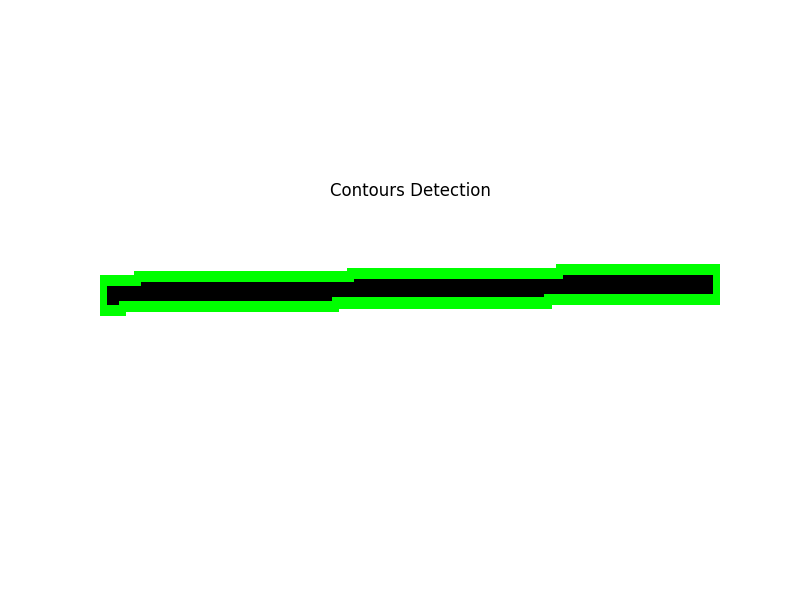

In [16]:


# 其它方法



# 二值化處理
_, binary = cv2.threshold(img_gray_roi, 128, 255, cv2.THRESH_BINARY_INV)

# 去除雜訊
kernel = np.ones((3, 3), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)


# 找輪廓
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 創建彩色影像來繪製輪廓
img_temp = cv2.cvtColor(img_gray_roi, cv2.COLOR_GRAY2BGR)

# 繪製輪廓
cv2.drawContours(img_temp, contours, -1, (0, 255, 0), 2)  # 綠色輪廓，線寬2

# 使用 Matplotlib 顯示結果
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_temp, cv2.COLOR_BGR2RGB))  # OpenCV 的 BGR 轉 RGB
plt.title("Contours Detection")
plt.axis("off")  # 移除座標軸
plt.show()

